# Stock Price Prediction

In this notebook, we demonstrate a reference use case where we use historical stock price data to predict the future price. The dataset we use is the daily stock price of S&P500 stocks during 2013-2018 ([data source](https://www.kaggle.com/camnugent/sandp500/)). We demostrate how to do univariate forecasting using the past 80% of the total days' MMM price to predict the future 20% days' daily price.

Reference: https://github.com/jwkanggist/tf-keras-stock-pred



## Get Data

We will use the close prices of MMM stock for our experiment. We will
  1. download raw dataset and load into dataframe.
  2. Extract the close prices of MMM stock from the dataframe into a numpy array

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!unzip /content/superai5-stock-price-prediction.zip

Archive:  /content/superai5-stock-price-prediction.zip
  inflating: X_test.csv              
  inflating: X_train.csv             
  inflating: sample_submission.csv   
  inflating: submission.csv          
  inflating: y_train.csv             


In [4]:
# read data
data = pd.read_csv("/content/X_train.csv")
print(data[:10])

   Id         High          Low         Open  Volume
0   0  1528.699951  1518.000000  1518.099976     214
1   1  1552.699951  1530.099976  1530.099976     107
2   2  1580.000000  1560.400024  1580.000000     416
3   3  1576.300049  1558.300049  1558.300049      47
4   4  1604.199951  1552.300049  1579.699951     236
5   5  1555.699951  1543.300049  1555.699951      54
6   6  1558.800049  1545.400024  1551.199951      16
7   7  1558.000000  1548.400024  1557.400024      48
8   8  1546.699951  1534.900024  1546.699951      32
9   9  1553.900024  1545.599976  1548.000000      11


In [5]:
y = pd.read_csv("/content/y_train.csv")

print(y[:10])

   Id        Close
0   0  1524.500000
1   1  1549.199951
2   2  1566.199951
3   3  1571.800049
4   4  1557.400024
5   5  1551.699951
6   6  1557.500000
7   7  1548.400024
8   8  1542.400024
9   9  1552.099976


In [ ]:
# # extract close value
# close_val = target_rows[['close']].values
# print(close_val[:10])

[[102.66]
 [102.62]
 [103.46]
 [102.86]
 [102.78]
 [103.23]
 [104.18]
 [103.15]
 [102.72]
 [103.54]]


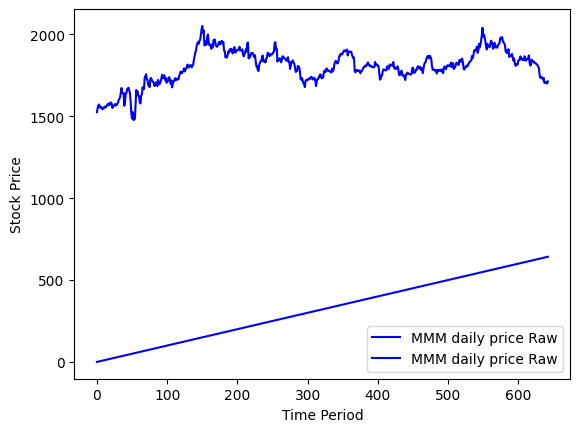

In [7]:
# Visualize data

import matplotlib.pyplot as plt
plt.plot(y, color='blue', label='MMM daily price Raw')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [14]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

# Approach 1 : AutoGluon Time Series Predictor

In [15]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [46]:
# Load your data into pandas DataFrames
X_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")
X_test = pd.read_csv("/content/X_test.csv") # Assuming you have X_test

# X_train = X_train.reset_index(drop=True)
# X_train['Id'] = X_train.index  # Create 'Id' column if it doesn't exist

# y_train = y_train.reset_index(drop=True)
# y_train['Id'] = y_train.index  # Create 'Id' column if it doesn't exist

# # Merge X_train and y_train to create a single training DataFrame
# train_data = pd.merge(X_train, y_train, on='Id')

* TabularPredictor

In [53]:
import pandas as pd
from autogluon.tabular import TabularPredictor

def preprocess_stock_data(X_train, y_train, X_test):
    """
    Preprocesses stock price data for AutoGluon.

    Args:
        X_train (pd.DataFrame): Training features (Id, High, Low, Open, Volume).
        y_train (pd.DataFrame): Training target (Id, Close).
        X_test (pd.DataFrame): Test features (Id, High, Low, Open, Volume).

    Returns:
        tuple: (train_data, test_data, predictor)
            train_data (pd.DataFrame): Combined training data.
            test_data (pd.DataFrame): Test data.
            predictor (TabularPredictor): AutoGluon TabularPredictor instance.
    """

    # Merge X_train and y_train based on 'Id'
    train_data = pd.merge(X_train, y_train, on='Id')

    # Drop 'Id' from train and test data (AutoGluon doesn't need it as a feature)
    train_data = train_data.drop('Id', axis=1)
    test_data = X_test.drop('Id', axis=1)

    # Specify the target column
    target = 'Close'

    # Initialize the TabularPredictor
    predictor = TabularPredictor(label=target, eval_metric='mean_squared_error').fit(train_data)

    return train_data, test_data, predictor

def predict_stock_prices(X_train, y_train, X_test):
    """
    Trains an AutoGluon model and predicts stock prices.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.DataFrame): Training target.
        X_test (pd.DataFrame): Test features.

    Returns:
        pd.Series: Predicted stock prices.
    """
    train_data, test_data, predictor = preprocess_stock_data(X_train, y_train, X_test)

    # Make predictions on the test data
    predictions = predictor.predict(test_data)

    return predictions

In [54]:
# Predict stock prices
predictions = predict_stock_prices(X_train, y_train, X_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20250228_134335"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.30 GB / 12.67 GB (81.3%)
Disk Space Avail:   74.62 GB / 112.64 GB (66.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

[1000]	valid_set's l2: 171.036
[2000]	valid_set's l2: 158.236
[3000]	valid_set's l2: 153.537
[4000]	valid_set's l2: 152.119


	-151.2118	 = Validation score   (-mean_squared_error)
	0.97s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	-144.645	 = Validation score   (-mean_squared_error)
	0.4s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-112.0597	 = Validation score   (-mean_squared_error)
	0.58s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-119.1181	 = Validation score   (-mean_squared_error)
	8.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-104.8051	 = Validation score   (-mean_squared_error)
	0.73s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-76.4763	 = Validation score   (-mean_squared_error)
	0.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-98.4894	 = Validation score   (-mean_squared_error)
	0.95s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch

In [55]:
# Print the predictions
print(predictions)

0      1729.221436
1      1727.994263
2      1722.750000
3      1720.962524
4      1746.482666
          ...     
638    2053.095703
639    2053.095703
640    2053.095703
641    2053.095703
642    2053.095703
Name: Close, Length: 643, dtype: float32


In [64]:
#If you need to add the Id back to the prediction results.
predictions_with_id = pd.DataFrame({'Id': X_test['Id'].values, 'Close': predictions.values})
print(predictions_with_id)

       Id        Close
0     643  1729.221436
1     644  1727.994263
2     645  1722.750000
3     646  1720.962524
4     647  1746.482666
..    ...          ...
638  1281  2053.095703
639  1282  2053.095703
640  1283  2053.095703
641  1284  2053.095703
642  1285  2053.095703

[643 rows x 2 columns]


In [65]:
# Save predictions to a CSV file
predictions_with_id.to_csv('first_submission.csv', index=False)

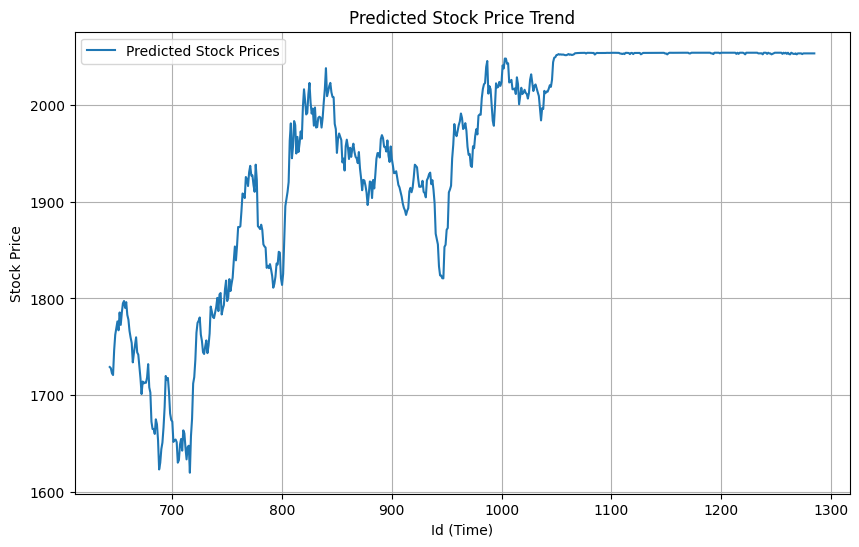

In [57]:
import matplotlib.pyplot as plt

# Assuming 'predictions_with_id' DataFrame is already created

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(predictions_with_id['Id'], predictions_with_id['Close'], label='Predicted Stock Prices')
plt.xlabel("Id (Time)")
plt.ylabel("Stock Price")
plt.title("Predicted Stock Price Trend")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
predictor = TimeSeriesPredictor(
    prediction_length=1, # 24 hours
    path="autogluon-m4-hourly",
    target="Close",
    eval_metric="MSE",
    freq="D",
)

predictor.fit(
    train_tsdf, # pass the merged DataFrame here with target column
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.66 GB / 12.67 GB (84.1%)
Disk Space Avail:   74.70 GB / 112.64 GB (66.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'Close',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to freque

ValueError: At least some time series in train_data must have >= 6 observations. Please provide longer time series as train_data or reduce prediction_length, num_val_windows, or val_step_size.

# Chronos Time-Series

## Data Pre-processing
Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset.

For the stock price data we're using, the processing contains 2 parts:

1.   Data normalization such that the normalized stock prices fall in the range of 0 to 1
2.   Extract time series of given window size

We generate a built-in TSDataset to complete the whole processing.



In [12]:
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler

# Assuming your data is in a DataFrame called 'data'
# with columns 'date' for datetime and 'close' for the target variable
df = data[['date', 'close']]

# Create the TSDataset
tsdata_train, _, tsdata_test = TSDataset.from_pandas(
    df,
    dt_col="date",  # Replace with your datetime column name
    target_col="close",  # Replace with your target column name
    with_split=True,
    test_ratio=0.2
)

# Data scaling
minmax_scaler = MinMaxScaler()
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train)) \
          .roll(lookback=50, horizon=1)  # Adjust lookback and horizon as needed

X_train, y_train = tsdata_train.to_numpy()
X_test, y_test = tsdata_test.to_numpy()

TypeError: code expected at least 16 arguments, got 15

In [13]:
import pandas as pd
import numpy as np
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler

# Create a range of values as a substitute for the date column
date_range = pd.date_range(start='2013-01-01', periods=len(y), freq='D')

# Convert y to a DataFrame with the date_range as index
y = y.set_index(date_range)
y.columns = ['close']  # Rename the column to 'close'

# Create the TSDataset
tsdata_train, _, tsdata_test = TSDataset.from_pandas(
    y,
    dt_col=y.index.name,  # Use the index name as dt_col
    target_col="close",
    with_split=True,
    test_ratio=0.2
)

# Data scaling
minmax_scaler = MinMaxScaler()
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train)) \
          .roll(lookback=50, horizon=1)

X_train, y_train = tsdata_train.to_numpy()
X_test, y_test = tsdata_test.to_numpy()

ImportError: cannot import name 'MutableMapping' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

## Time series forecasting

We use LSTMForecaster for forecasting.

In [ ]:
from zoo.chronos.forecaster.lstm_forecaster import LSTMForecaster

First we initiate a LSTMForecaster.


*   `feature_dim` should match the dimension of the input data, so we just use the last dimension of train input data shape
*   `target_dim` equals the dimension of the output data, here we set `target_dim=1` for univariate forecasting.



In [ ]:
# Hyperparameters
feature_dim = X_train.shape[-1]
target_dim = 1
hidden_dim = 10
learning_rate = 0.01
batch_size = 16
epochs = 50

In [ ]:
# build model
forecaster = LSTMForecaster(past_seq_len=X_train.shape[1],
                            input_feature_num=feature_dim,
                            output_feature_num=target_dim,
                            hidden_dim=32,
                            lr=learning_rate,
                            )


Then we use fit to train the model. Wait sometime for it to finish.

In [ ]:
%%time
forecaster.fit(data=(X_train, y_train), batch_size=batch_size, epochs=epochs)

/home/junweid/anaconda3/envs/automl/lib/python3.6/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Loss: 0.00028104399098083377: 100%|██████████| 60/60 [00:00<00:00, 129.21it/s]


CPU times: user 3min 54s, sys: 411 ms, total: 3min 55s
Wall time: 23.5 s


{'mse': 0.00035006429045537625}


After training is finished. You can use the forecaster to do prediction and evaluation.

In [ ]:
# make prediction
y_pred = forecaster.predict(X_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too.

In [ ]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

Calculate the mean square error.

In [ ]:
# evaluate with mean_squared_error
from zoo.orca.automl.metrics import Evaluator
print("mean_squared error is", Evaluator.evaluate("mse", y_test_unscale, y_pred_unscale, multioutput='uniform_average'))

mean_squared error is 13.068279890736278


Visualize the prediction.

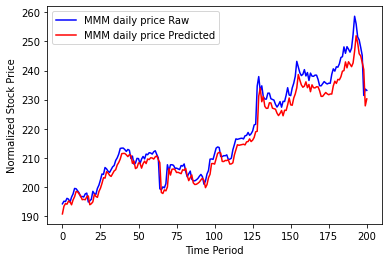

In [ ]:
# Plot predictions
plt.plot(y_test_unscale[:, :, 0], color='blue', label="MMM daily price Raw")
plt.plot(y_pred_unscale[:, :, 0], color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()